<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第五章：在无标签数据上预训练

In [3]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow"
]
for p in pkgs:
    try:
        print(f"{p} verison: {version(p)}")
    except ImportError:
        print(f"{p} is not installed")

matplotlib verison: 3.7.5
numpy verison: 1.26.4
tiktoken verison: 0.8.0
torch verison: 2.0.1+cu118
tensorflow is not installed


- 本章节实现训练和评估一个预训练LLM的初步代码
- 结尾也将OpenAI发布的预训练权重加载到本节实现的模型中

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp">
</p>

- 本章节覆盖的主体如下图所示

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp" width=800px>
</p>

## 5.1 评估生成文本模型
- 先使用之前章节中的代码初始化一个GPT模型进行一个简短的回顾
- 然后讨论评价LLMs的基础指标/metrics
- 最后将评价指标应用到训练和测试数据集

### 5.1.1 使用GPT生成文本
- 使用之前的代码初始化一个GPT模型

In [7]:
import torch

from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 设置为评估模式，关闭dropout

- 上面使用了0.1的dropout，但现在训练LLM时不使用dropout已经相对常见
- 现代的LLM也不在`nn.Linear`层中使用偏置向量（不同于早期的GPT模型），这是通过设置`"qkv_bias": False`实现的
- 将上下文长度(`context_length`)减少到256个token，以减少训练模型的计算资源需求，而原始的124M参数的GPT-2模型使用了1024个token
  - 这样做是为了让更多的读者能够跟随和执行代码示例，而原始的124M参数的GPT-2模型使用了1024个token
  - 然而，请随意增加`context_length`到1024个token（这不需要任何代码更改）
  - 稍后也会从预训练权重加载一个1024 `context_length`的模型

- 接下来，使用上一章节的`generate_text_simple`函数生成文本
- 此外，还定义了两个功能函数，`text_to_token_ids`和`token_ids_to_text`，用于在token和文本表示之间进行转换，本章节中会使用它们

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=800px>
</p>

In [8]:
import tiktoken

from previous_chapters import generate_text_simple


def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 加一个batch维度
    return encoded_tensor


def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    flat = token_ids.squeeze(0)  # 移除添加的batch维度
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所见，模型尚未产生良好的文本，这是因为它还没有经过训练
- 如何以数字形式衡量或捕捉"好文本"是什么，以便在训练过程中追踪它？
- 下一小节介绍用于计算生成输出损失指标的度量，可以使用这些指标来衡量训练进度
- 接下来的关于微调LLMs的章节也将介绍更多衡量模型质量的方法

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度
- 假设有一个`inputs`张量，其中包含了2个训练样本（行）的词元（token）ID
- 与`inputs`相对应，`targets`包含了希望模型生成的目标词元（token）ID
- 注意`targets`是将`inputs`向后移动1个位置得到的，正如在第2章实现数据加载器时所解释的那样

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将`inputs`输入模型后，获得了2个输入样例的logits向量，每个样例包含3个tokens
- 每个token是一个50,257维的向量，对应词汇表的大小
- 应用softmax函数，可以将logits张量转换为相同维度的张量，其中包含概率分数

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)  # 词表中每个token的概率
print(probas.shape)  # shape [batch_size, num_tokens, vocab_size]

torch.Size([2, 3, 50257])


- 下图使用了一个非常小的词汇表进行说明，概述了如何将概率分数转换回文本，这是在上一章末尾讨论过的内容

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=800px>
</p>

- 正如在上一章中讨论的，可以应用`argmax`函数将概率分数转换为预测的token ID
- 上面的softmax函数为每个token生成了一个50,257维的向量；`argmax`函数返回这个向量中最高概率分数的位置，即给定token的预测token ID

- 因为输入batch中包含两个样例，每个样例三个tokens，所以得到的token IDs也是相同形状的张量

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs: \n", token_ids)
print("Shape of token IDs: \n", token_ids.shape)

Token IDs: 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Shape of token IDs: 
 torch.Size([2, 3, 1])


- 如果解码上述tokens，可能发现其与希望的预测tokens非常不同

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还未训练
- 为了训练模型，需要知道预测的结果与正确的结果还相差多远

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=800px>
</p>

- 目标索引对应的tokens概率如下所示

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 目标是最大化所有这些值，使它们接近概率1
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；这在本书的范围内不讨论，下面链接资源详细介绍了这个概念：[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [11]:
# 计算所有token概率的对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 下一步计算平均对数概率

In [12]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是使这个平均对数概率尽可能大，通过优化模型权重
- 由于对数，最大可能值是0，目前离0还很远

- 在深度学习中，不是最大化平均对数概率值，而是最小化平均对数概率的负数；本章节例子中，不是最大化-10.7722，使其接近0，而是最小化10.7722，使其接近0
- 负的-10.7722，即10.7722，在深度学习中也称为交叉熵损失

In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- Pytorch中内部实现了上述计算过程的交叉熵计算函数 `cross_entropy`

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=800px>
</p>

- 在应用`cross_entropy`之前，需要检查logits和targets的形状

In [14]:
# Logits的shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets的shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的`cross_entropy`函数，希望通过在批次维度上合并这些张量来将它们展平

In [15]:
logits_flat = logits.flatten(0, 1)  # 将前两维展平
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 注意targets是token IDs，也代表了logits张量中希望最大化的token索引位置
- **PyTorch中的`cross_entropy`函数会自动在logits中应用softmax和log-概率计算，内部处理那些需要最大化的token索引位置**

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 一个和交叉熵损失相关的概念是LLM的困惑度
- 困惑度是交叉熵损失的指数

In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更易于解释，因为它可以被理解为模型在每个步骤中对词汇量（在上述例子中，是48,725个单词或token）的不确定性
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词实际分布之间匹配程度的指标
- 类似地，损失值越低，模型预测越接近实际分布

### 5.1.3 计算训练集和验证机的损失
- 使用一个相对较小的数据集来训练LLM（实际上，只有一篇短故事）
- 原因如下：
  - 可以在没有合适GPU的笔记本电脑上几分钟内运行代码示例
  - 训练相对较快（几分钟而不是几周），这对于教育目的非常有用
  - 使用的是公共领域的文本，可以在不违反任何使用权利或增加仓库大小的情况下包含在GitHub仓库中


- 例如，Llama 2 7B在A100 GPU上训练2万亿个token需要184,320个GPU小时
  - 截至撰写本文时，8xA100云服务器在AWS上的每小时成本约为30美元
  - 因此，通过一个粗略的计算，训练这个LLM将花费184,320 / 8 * 30 = 690,000美元
 
- 下面，使用的是第2章中使用的相同数据集

In [2]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.

        
# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode('utf-8')
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()

- 通过打印第一个和最后99个字符来快速检查文本加载是否正常

In [3]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [4]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [9]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 5145个tokens，文本非常短，不足以训练一个LLM，但再次强调，这是为了教育目的（稍后也会加载预训练权重）

- 接下来，将数据集分为训练集和验证集，并使用第2章中的数据加载器准备LLM训练的批次
- 为了可视化目的，下面的图假设`max_length=6`，但对于训练加载器，将`max_length`设置为LLM支持的上下文长度
- 下面的图只显示输入token，以便于简化
    - 因为训练LLM来预测文本中的下一个词，所以目标看起来与这些输入相同，只是目标向右移动了一个位置

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=800px>
</p>

In [21]:
from previous_chapters import create_dataloader_v1

# 训练/验证集的划分
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M["context_length"],
                                    stride=GPT_CONFIG_124M["context_length"],
                                    drop_last=True,
                                    shuffle=True,
                                    num_workers=0)

val_loader = create_dataloader_v1(val_data,
                                  batch_size=2,
                                  max_length=GPT_CONFIG_124M["context_length"],
                                  stride=GPT_CONFIG_124M["context_length"],
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=0)

In [22]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 使用相对较小的批量大小来减少计算资源需求，因为数据集本身很小
- Llama 2 7B训练时使用的批量大小为1024

- 以下是一个可选的检查，确保数据正确加载

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选的检查是确认token大小在预期的范围内

In [24]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，实现一个函数来计算给定批次的交叉熵损失
- 此外，实现一个函数来计算数据加载器中用户指定数量的批次的损失

In [ ]:
def calc_loss_batch(input_batch: torch.Tensor, target_batch: torch.Tensor,
                    model: torch.nn.Module, device: torch.device) -> torch.Tensor:
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module,
                     device: torch.device, num_batches: int = None) -> float:
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果num_batches超过数据加载器中的总批次数，则减少批次数以匹配数据加载器中的总批次数
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

- 如果有支持CUDA的GPU，LLM将使用GPU训练，而不需要任何代码更改
- 通过`device`设置，确保数据加载到与LLM模型相同的设备上

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # 将模型移动到GPU或CPU


torch.manual_seed(123) # 为了可重复性，由于数据加载器中的打乱

with torch.no_grad(): # 为了效率，禁用梯度跟踪，因为还没有训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp" width=800px>
</p>

## 5.2 训练一个LLM
- 本小节实现训练LLM的完整代码
- 主要专注于一个简单的训练函数，如果对使用更高级技术来增强这个训练函数感兴趣，比如学习率预热、余弦退火和梯度裁剪，请参考[Appendix D](../../appendix-D/01_main-chapter-code)

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=800px>
</p>

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 现在开始训练LLM

In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.934
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.340
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.052
Ep 2 (Step 000015): Train loss 6.048, Val loss 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.591, Val loss 6.479
Ep 3 (Step 000025): Train loss 5.553, Val loss 6.413
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.177, Val loss 6.367
Ep 4 (Step 000035): Train loss 4.987, Val loss 6.379
Every effort moves you a a, and a a, and the a, and a. Gisburn, and a, and the of the of the of the a. I had the a, and a. I had the of the a of the of the of
Ep 5 (Step 000040): Train loss 4.351, Val loss 6.276
Every effort moves you, I had been, I had been, I had been a 

- 注意在不同的计算机上可能会得到略有不同的损失值，如果它们大致相似（训练损失低于1，验证损失低于7），则没有必要担心
- 小的差异通常可能是由于不同的GPU硬件和CUDA版本，或者较新PyTorch版本中的微小变化导致的
- 即使在CPU上运行这个示例，也可能会观察到轻微的差异；可能导致差异的一个原因是nn.Dropout在不同操作系统上的行为不同，这取决于PyTorch的编译方式，正如[here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)中讨论的

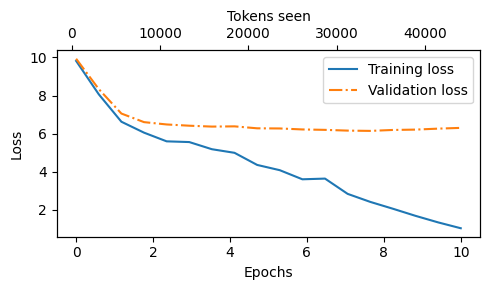

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen: int, tokens_seen: int, train_losses, val_losses) -> None:
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从上面的结果可以看到模型最初生成的是难以理解的词语字符串，而到了后期，它能够生成语法上或多或少正确的句子
- 然而，根据训练集和验证集的损失，可以看到模型开始出现过拟合
- 如果检查它在训练结束时写出的几段文字，会发现它们完全照搬自训练集中的内容——模型只是简单地记忆了训练数据
- 稍后将介绍一些解码策略，这些策略可以在一定程度上缓解这种记忆现象
- 注意，这里出现的过拟合是因为训练集非常非常小，而且对它进行了多次迭代
  - 这里的LLM训练主要是出于教育目的，主要想看到模型能够学习生成连贯的文本
  - 不可能花费数周或数月的时间在大量昂贵的硬件上训练这个模型，而是在后面加载预训练权重

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/13.webp" width=800px>
</p>

**如果对使用更高级的技术来增强这个训练函数感兴趣，例如学习率预热、余弦退火和梯度裁剪，请参考[Appendix D](../../appendix-D/01_main-chapter-code)**

**如果对更大的训练数据集和更长时间的训练运行感兴趣，请看靠[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 控制随机性的解码策略
- 对于像上面训练的GPT这样相对较小的LLM来说，推理的计算成本相对较低，所以即使在上面的训练过程中使用了GPU，进行推理时也不需要使用GPU
- 使用之前在简单训练函数中使用的`generate_text_simple`函数，可以一次生成一个词（或token）
- 如第5.1.2节所述，下一个生成的token是词汇表中所有token中概率得分最大的token

In [41]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

tokend_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]  
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to


- 即使多次执行上面的`generate_text_simple`函数，LLM也会始终生成相同的输出
- 现在引入两个概念，即所谓的解码策略，来修改generate_text_simple：温度缩放（temperature scaling）和top-k采样
- 这些策略将允许模型控制生成文本的随机性和多样性

### 5.3.1 温度缩放
- 之前，总是使用`torch.argmax`来采样下一个token，即具有最高概率的token
- 为了增加多样性，可以使用`torch.multinomial(probs, num_samples=1)`，从概率分布中采样
- 这里，每个索引被选中的几率与其在输入张量中的概率相对应

- 这里简单回顾一下生成下一个词元的过程，假设词汇量非常小，仅用于说明目的

In [42]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}  # 反向词汇表

# 假设 input 是 "every effort moves you", 并且 LLM 为下一个token返回以下logits
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 生成的下一个token如下：
print(inverse_vocab[next_token_id])

forward


In [51]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


- 不是通过`torch.argmax`来确定最可能的token，而是使用`torch.multinomial(probas, num_samples=1)`从softmax分布中采样来确定最可能的token
- 为了说明目的，可以看看使用原始softmax概率对下一个token进行1,000次采样时会发生什么

In [53]:
def print_sampled_tokens(probas: torch.Tensor) -> None:
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 可以通过称为温度缩放的概念控制概率分布和生成过程
- 温度缩放只是一个好听、fancy的名字，本质就是将logits除以一个大于0的数
- 大于1的温度将导致应用softmax后的词元概率分布更加均匀
- 小于1的温度将导致应用softmax后的概率分布更加具体（更尖锐或更集中）

- 注意，根据作系统不同，生成的dropout输出可能看起来不同；可以在[here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)上阅读更多关于这种不一致性的信息

In [54]:
def softmax_with_temperature(logits: torch.Tensor, temperature: float) -> torch.Tensor:
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


# 测试的温度值列表
temperatures = [1, 0.1, 5]

# 计算scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

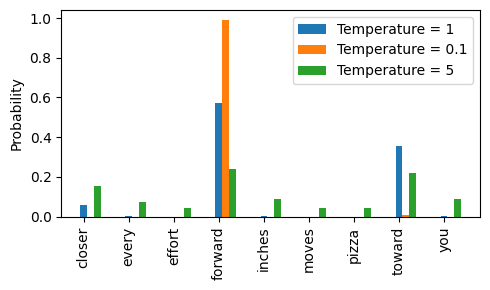

In [55]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 可以看到，通过温度0.1进行重新缩放会产生更尖锐的分布，接近于torch.argmax的效果，使得最可能的词几乎总是被选中

In [56]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you


- 通过温度5重新缩放的概率分布更加均匀

In [57]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


- 假设LLM输入为"every effort moves you"，使用上述方法有时会产生无意义的文本，比如"every effort moves you pizza"，这种情况出现的概率为4.3%（1000次中有43次，具体情况各不相同）

### 5.3.2 Top-k采样
- 为了能够使用更高的温度来增加输出多样性，并降低产生无意义句子的概率，可以将采样的tokens限制在最可能的前k个词元中

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=800px>
</p>

- 注意，此图中的数字保留小数点后两位，以减少视觉混乱。Softmax行中的值应该加起来等于1.0
- 代码实现如下

In [59]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, k=top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [60]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  # 将所有低于top-k的logits设置为-inf
    input=torch.tensor(float("-inf")),  # 如果条件为真，返回-inf
    other=next_token_logits  # 如果条件为假，返回原始logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：
>
> 一个稍微更高效的实现上述代码单元的方法如下：
>
> ```python
> new_logits = torch.full_like(  # 创建包含-inf值的张量
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # 将top-k值复制到-inf张量中
> ```
> <br>
> 更多细节减 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [61]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 调整文本生成函数

- 前两个小节介绍了温度采样和top-k采样
- 使用这两个概念来修改之前第4章中用于通过LLM生成文本的`generate_text_simple`函数，创建一个新的`generate`函数

In [ ]:
def generate(model, idx: torch.Tensor, max_new_tokens: int, context_size: int,
             temperature: float = 0.0, top_k: int = None, eos_id: int = None) -> torch.Tensor:
    # 与之前函数中循环一样，获取logits，只关注最后一步
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 只关注最后一步

        # 使用top-k采样
        if top_k is not None:
            top_logits, _ = torch.topk(logits, k=top_k)
            logits = torch.where(
                condition=logits < top_logits[:, -1],
                input=torch.tensor(float("-inf")).to(logits.device),
                other=logits
            )

        # 使用温度缩放
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # [batch_size, context_len]
            idx_next = torch.multinomial(probs, num_samples=1)  # [batch_size, 1]
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # [batch_size, 1]

        if idx_next == eos_id:  # 若预测出eos_id，提前结束采样循环
            break
        
        idx = torch.cat((idx, idx_next), dim=1)  # [batch_size, num_tokens+1]

    return idx

In [67]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a good _ himself it was no
"I enough


## 5.4 在Pytorch中加载和保存模型权重
- 训练LLMs是非常贵的, 因此保存和加载LLMs权重是至关重要的

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/16.webp" width=800px>
</p>

- 在PyTorch中推荐的方法是通过对.state_dict()方法应用torch.save函数来保存模型权重，即所谓的state_dict

In [68]:
torch.save(model.state_dict(), "model.pth")

- 按以下方法可以将保存的模型权重加载到一个新的`GPTModel`模型实例中

In [ ]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

/home/dbt/miniconda3/envs/cosyvoice/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


- 通常使用自适应优化器如Adam或AdamW而不是常规SGD来训练LLM是很常见的
- 这些自适应优化器为每个模型权重存储额外的参数，因此如果计划稍后继续预训练，保存这些参数也是有意义的

In [70]:
torch.save({
    "model_state_dict": model.state_dict(),  # 模型权重
    "optimizer_state_dict": optimizer.state_dict(),  # 优化器相关参数
    }, 
    "model_and_optimizer.pth"
)

In [71]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 加载OpenAI发布的预训练模型

- 之前，出于教育目的使用一本非常小的短篇故事书训练了一个小型GPT-2模型
- 有兴趣的读者也可以在[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)中找到在完整的Project Gutenberg图书语料库上进行的更长时间的预训练运行
- 幸运的是，不必花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以加载由OpenAI提供的预训练权重

---

---


⚠️ **注意: 某些读者可能会在本节中遇到问题，这是由于TensorFlow兼容性问题，特别是在某些Windows系统上。这里需要TensorFlow仅仅是为了加载原始的OpenAI GPT-2权重文件，然后将其转换为PyTorch格式。如果遇到与TensorFlow相关的问题，可以使用下面的替代代码，而不是本节中剩余的代码。这个替代方案基于预先转换的PyTorch权重，使用的是前一节中描述的相同转换过程创建的。
有关详细信息，请参考该notebook：
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) notebook.**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码用于从OpenAI下载文件并将权重加载到Python中
- 由于OpenAI使用了[TensorFlow](https://www.tensorflow.org/)，需要安装和使用TensorFlow来加载权重；[tqdm](https://github.com/tqdm/tqdm)是一个进度条库
- 取消注释并运行下一个单元格以安装所需的库

In [72]:
! pip install tensorflow tqdm

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 6.3 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 6.2 MB/s eta 0:00:0000:0100:01


In [73]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.66.5


In [74]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2

2025-05-25 22:55:11.029139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 22:55:11.063765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748184911.086632  271508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748184911.093563  271508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748184911.111884  271508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

---

**Note**

- 在极少数情况下，上述代码单元可能会导致`zsh: illegal hardware instruction python`错误，这可能是由于TensorFlow安装问题
- 有读者发现通过`conda`安装TensorFlow解决了这个问题，如[这里](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)所述
- 可以在[这个补充的Python设置教程](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)中找到更多信息
---

- 可以如下下载124百万参数的模型权重

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

In [ ]:
print("Settings:", settings)

In [ ]:
print("Parameter dictionary keys:", params.keys())

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

- 也可以使用`model_size`参数选择"355M", "774M" 和 "1558M"
- 这些不同大小的模型之间的差异总结在下面的图中

<p align="center">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/17.webp" width=800px>
</p>

- 上面，将124M GPT-2模型权重加载到Python中，但仍然需要将它们转移到`GPTModel`实例中
- 首先，初始化一个新的GPTModel实例
- 注意，原始GPT模型在多头注意力模块中使用偏置向量初始化查询、键和值矩阵的线性层，这并不是必需或推荐的；但是，为了能够正确加载权重，也必须通过在实现中设置`qkv_bias`为`True`来启用这些
- 还使用了原始GPT-2模型使用的`1024`令牌上下文长度

In [79]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 下一个任务是将OpenAI的权重分配给`GPTModel`实例中对应的权重张量

In [81]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型正确加载，可以使用之前的generate函数来生成新文本

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- 以上表明模型权重已经正确加载，因为模型能够生成连贯的文本；如果犯了哪怕是很小的错误，模型都将无法做到这一点
# 
- 关于从Hugging Face Hub加载权重的另一种方式，请参见 [../02_alternative_weight_loading](../02_alternative_weight_loading)
- 如果有兴趣了解GPT架构与Llama架构（由Meta AI开发的流行LLM）的比较，请查看 [../07_gpt_to_llama](../07_gpt_to_llama) 的额外内容

## 总结与收获

- 查看 [./gpt_train.py](./gpt_train.py) 脚本，这是一个用于训练的独立脚本
- [./gpt_generate.py](./gpt_generate.py) 脚本从OpenAI加载预训练权重，并基于提示生成文本
- 可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习题的解答